In [ ]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [ ]:
# Specify data paths
dataset = 'keypoint.csv'
model_save_path = 'keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [ ]:
# Change training classes if necessary
NUM_CLASSES = 8

# Dataset reading

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1595, 1663, 1510,  672,  164,  257,  139,  190]))


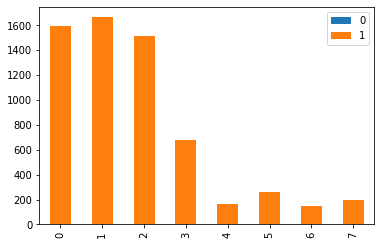

In [ ]:
# Classes count
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

# Model building

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_582 (Dropout)        (None, 42)                0         
_________________________________________________________________
dense_776 (Dense)            (None, 32)                1376      
_________________________________________________________________
dropout_583 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_777 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_584 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_778 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_779 (Dense)            (None, 8)              

In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [ ]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
73/73 [==============================] - 1s 5ms/step - loss: 1.9596 - accuracy: 0.3092 - val_loss: 1.4591 - val_accuracy: 0.3941

Epoch 00001: val_loss improved from inf to 1.45908, saving model to keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/1000
73/73 [==============================] - 0s 3ms/step - loss: 1.3146 - accuracy: 0.4974 - val_loss: 0.8803 - val_accuracy: 0.7481

Epoch 00002: val_loss improved from 1.45908 to 0.88032, saving model to keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.7921 - accuracy: 0.7591 - val_loss: 0.4876 - val_accuracy: 0.8605

Epoch 00003: val_loss improved from 0.88032 to 0.48755, saving model to keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/1000
73/73 [==============================] - 0s 3ms/step - loss: 0.4508 - accuracy: 0.8783 - val_loss: 0.3009 - val_accuracy: 0.9367

Epoch 00004: val_loss improved from 0.48755 to 0.30093, saving model to keypoint_

In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Model evaluation
# TODO Test on loaded model
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

25/25 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9974


In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.0000000e+00 8.5401677e-12 1.5222527e-14 7.2429063e-11 3.3295724e-09
 2.5334020e-27 2.3049776e-16 3.3789385e-19]
0


# Confusion matrix

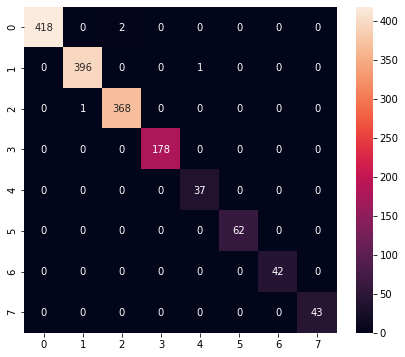

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      1.00      1.00       397
           2       0.99      1.00      1.00       369
           3       1.00      1.00      1.00       178
           4       0.97      1.00      0.99        37
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        42
           7       1.00      1.00      1.00        43

    accuracy                           1.00      1548
   macro avg       1.00      1.00      1.00      1548
weighted avg       1.00      1.00      1.00      1548



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpb_379rn7/assets


INFO:tensorflow:Assets written to: /tmp/tmpb_379rn7/assets


7840

## Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 117 µs, sys: 7 µs, total: 124 µs
Wall time: 132 µs


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 1.7798680e-13 5.1755124e-26 1.1783223e-18 1.0188586e-18
 1.1212574e-26 2.5901723e-24 2.6419864e-15]
0


## Download model

In [ ]:
!zip -r model.zip keypoint_classifier  

updating: keypoint_classifier/ (stored 0%)
updating: keypoint_classifier/keypoint_classifier.tflite (deflated 22%)
updating: keypoint_classifier/keypoint_classifier.hdf5 (deflated 60%)




---


# ❗️Hyperparameters Tuning

In [ ]:
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [ ]:
# Init parameters to tune
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([8, 16, 32]))
HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([8, 16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

In [ ]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS_1,HP_NUM_UNITS_2,HP_NUM_UNITS_3, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, verbose=1)

In [ ]:
def train_test_model(hparams):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS_3], activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
  
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
  
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)

  model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[
               cp_callback,
               es_callback,
               ]
  ) 

  # Load model with best accuracy
  model = tf.keras.models.load_model(model_save_path)

  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for num_units_3 in HP_NUM_UNITS_3.domain.values:
      for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, 0.1):
        for optimizer in HP_OPTIMIZER.domain.values:
          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_NUM_UNITS_3: num_units_3,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
          }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning/' + run_name, hparams)
          session_num += 1

Streaming output truncated to the last 5000 lines.
73/73 [==============================] - 0s 4ms/step - loss: 1.3139 - accuracy: 0.4863 - val_loss: 1.1672 - val_accuracy: 0.6234

Epoch 00019: val_loss improved from 1.21382 to 1.16716, saving model to keypoint_classifier/keypoint_classifier.hdf5
Epoch 20/50
73/73 [==============================] - 0s 4ms/step - loss: 1.2792 - accuracy: 0.4899 - val_loss: 1.1219 - val_accuracy: 0.6505

Epoch 00020: val_loss improved from 1.16716 to 1.12192, saving model to keypoint_classifier/keypoint_classifier.hdf5
Epoch 21/50
73/73 [==============================] - 0s 4ms/step - loss: 1.2310 - accuracy: 0.5082 - val_loss: 1.0747 - val_accuracy: 0.6544

Epoch 00021: val_loss improved from 1.12192 to 1.07474, saving model to keypoint_classifier/keypoint_classifier.hdf5
Epoch 22/50
73/73 [==============================] - 0s 4ms/step - loss: 1.1860 - accuracy: 0.5249 - val_loss: 1.0276 - val_accuracy: 0.6705

Epoch 00022: val_loss improved from 1.0747

In [ ]:
# !ATTENTION! Works only in Colab
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!rm -rf logs